<a href="https://colab.research.google.com/github/Ragnarok540/sympy-tutorial/blob/main/spring_mass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://www.youtube.com/watch?v=HaQwLfKOvKI
# https://www.youtube.com/watch?v=mX1VDOY6wVc

import sympy as smp
import sympy.physics.mechanics as smp_mech
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D

In [3]:
m, g, k, t, b = smp.symbols('m g k t b')
x = smp_mech.dynamicsymbols('x')

x_dot = smp.diff(x, t)
x_ddot = smp.diff(x_dot, t)

T = smp.Rational(1, 2) * m * x_dot**2
V = -m * g * x + smp.Rational(1, 2) * k * x**2
L = T - V

friction = True

if friction:
    eqn = smp.diff(smp.diff(L, x_dot), t) - smp.diff(L, x) + smp.diff(smp.Rational(1, 2) * b * x_dot**2, x_dot)
else:
    eqn = smp.diff(smp.diff(L, x_dot), t) - smp.diff(L, x)

sln = smp.solve(eqn, x_ddot)[0]
smp.Eq(x_ddot, sln)

Eq(Derivative(x(t), (t, 2)), (-b*Derivative(x(t), t) + g*m - k*x(t))/m)

In [4]:
if friction:
    fun = sln.subs([(g, 9.81), (m, 1), (k, 40), (b, 1)])
    l_fun = smp.lambdify([x, x_dot], fun)

    def spring_mass_ODE(t, y):
        return (y[1], l_fun(y[0], y[1]))

else:
    fun = sln.subs([(g, 9.81), (m, 1), (k, 40)])
    l_fun = smp.lambdify([x], fun)

    def spring_mass_ODE(t, y):
        return (y[1], l_fun(y[0]))

x0 = 0
x_dot0 = 0
t_final = 10
fps = 30

sol = solve_ivp(spring_mass_ODE,
                [0, t_final],
                (x0, x_dot0),
                t_eval=np.linspace(0, t_final, t_final * fps + 1))

x, x_dot = sol.y
t = sol.t

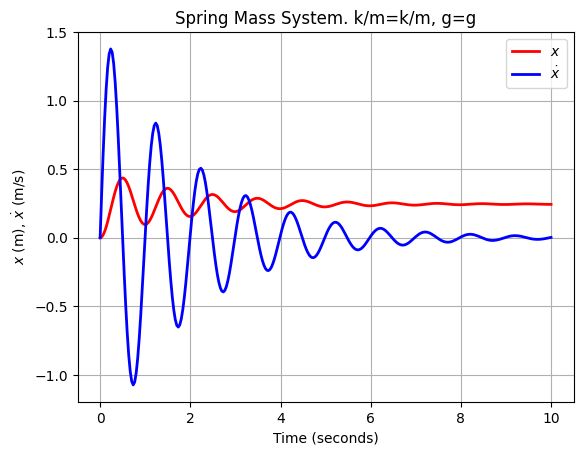

In [5]:
plt.plot(t, x, 'r', lw=2, label=r'$x$')
plt.plot(t, x_dot, 'b', lw=2, label=r'$\dot x$')
plt.title(f'Spring Mass System. k/m={k/m}, g={g}')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$x$ (m), $\dot x$ (m/s)')
plt.grid()
plt.show()

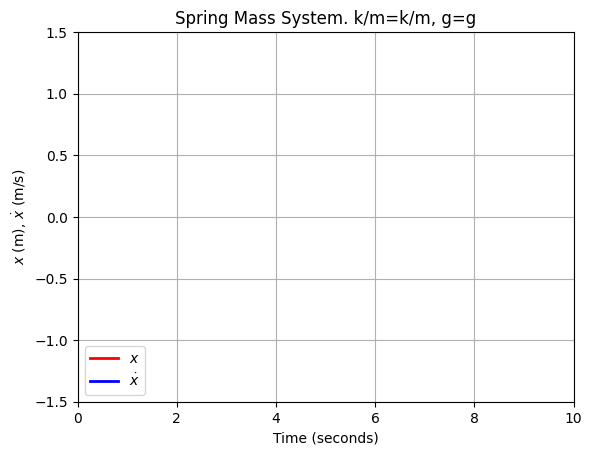

In [6]:
fig, ax = plt.subplots()

x_curve, = ax.plot(t[0], x[0], 'r', lw=2, label=r'$x$')
x_dot_curve, = ax.plot(t[0], x_dot[0], 'b', lw=2, label=r'$\dot x$')

ax.set_title(f'Spring Mass System. k/m={k/m}, g={g}')
ax.set_xlim(0, t_final)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r'$x$ (m), $\dot x$ (m/s)')
ax.legend(loc='lower left')
ax.grid()

def animate(i):
    x_curve.set_data(t[:i+1], x[:i+1])
    x_dot_curve.set_data(t[:i+1], x_dot[:i+1])

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save('time_domain.mp4', writer=ffmpeg_writer)
#ani.save('time_domain_with_friction.mp4', writer=ffmpeg_writer)

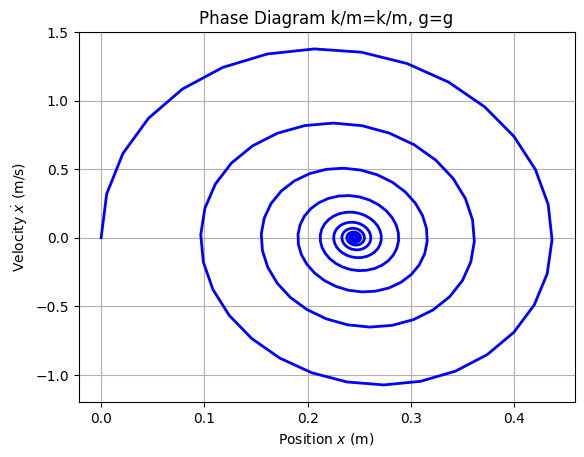

In [7]:
plt.plot(x, x_dot, 'b', lw=2)
plt.title(f'Phase Diagram k/m={k/m}, g={g}')
plt.xlabel(r'Position $x$ (m)')
plt.ylabel(r'Velocity $\dot x$ (m/s)')
plt.grid()
plt.show()

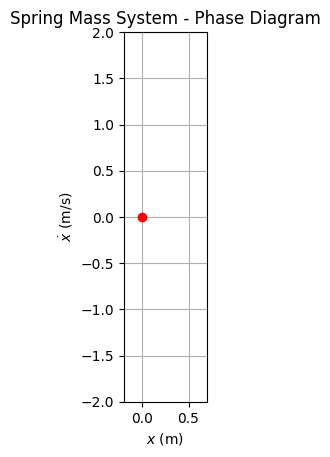

In [8]:
fig, ax = plt.subplots()

phase_curve, = ax.plot(x[0], x_dot[0], 'b')
phase_dot, =  ax.plot(x[0], x_dot[0], 'ro')

ax.set_title('Spring Mass System - Phase Diagram')
ax.set_aspect('equal')
ax.set_xlim(-0.2, 0.7)
ax.set_ylim(-2, 2)
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$\dot x$ (m/s)')
ax.grid()

def animate(i):
    phase_curve.set_data(x[:i+1], x_dot[:i+1])
    phase_dot.set_data([x[i]], [x_dot[i]])

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save('phase_diagram.mp4', writer=ffmpeg_writer)
#ani.save('phase_diagram_with_friction.mp4', writer=ffmpeg_writer)

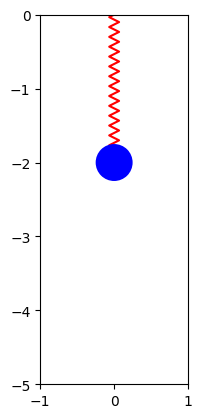

In [9]:
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-1, 1)
ax.set_ylim(-5, 0)

def generate_spring(n):
    data = np.zeros((2, n + 2))
    data[:, -1] = [0, -1]
    for i in range(1,n+1):
        data[0, i] = -1 / (2 * n) if i % 2 else 1 / (2 * n)
        data[1, i] = -(2 * i - 1) / (2 * n)
    return data

data = np.append(generate_spring(30), np.ones((1, 30 + 2)), axis=0)

ell = 2
y0 = -(ell + x0)
spring = Line2D(data[0,:], data[1,:], color='r')
circle = ax.add_patch(plt.Circle( (0, y0), 0.25, fc='b', zorder=3))
ax.add_line(spring)

def animate(i):
    y = -(ell + x[i])
    circle.set_center((0, y))

    stretch_factor = -y

    A = Affine2D().scale(8 / stretch_factor, stretch_factor).get_matrix()
    data_new = np.matmul(A, data)

    xn = data_new[0, :]
    yn = data_new[1, :]

    spring.set_data(xn, yn)

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save('spring_mass_affine.gif', writer=ffmpeg_writer)